## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-outdoor' 
TRANSFORM = 'wavelet-vertical'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_vertical_wavelet_outdoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\case-studies\\coco\\outdoor\\wavelet\\vertical\\gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 2446,
 3: 9784,
 4: 39136,
 5: 156544,
 6: 626176,
 7: 2504704,
 8: 10018816,
 9: 40075264}

Running 12760 CDFs


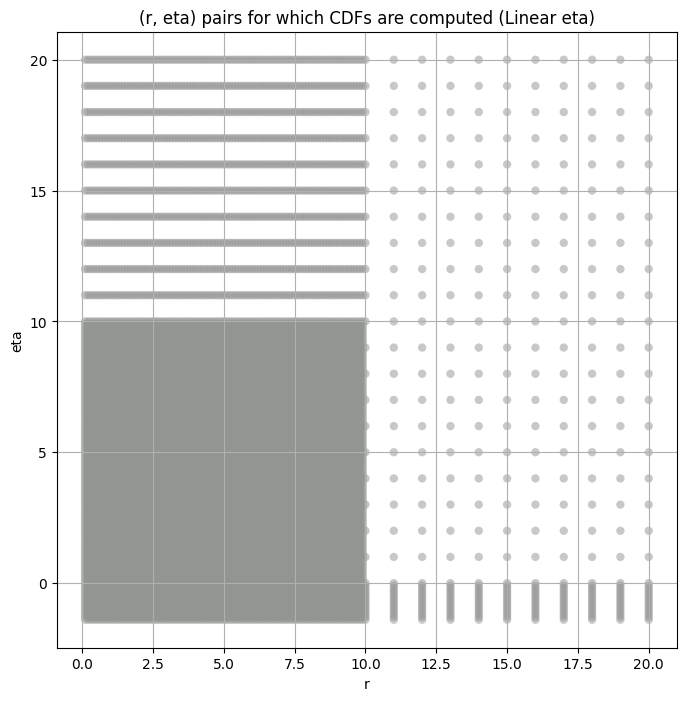

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      3000.960700  2751.604700  3260.011700   0.659391    0.358291   
3       820.214500   777.057400   865.321200   2.262863    1.942622   
4       189.177960   177.314650   201.591720   4.155531    3.484315   
5        42.683540    39.449863    46.217430   7.500519    5.473342   
6         9.066797     8.278472     9.960697  10.757481    7.695960   
7         1.883301     1.680134     2.205375  24.545399   10.354710   
8         0.438908     0.383545     0.550717  45.949707   12.866415   
9         0.121820     0.105568     0.162684  68.626060   13.538338   

       kurt_upper  total_samples  
layer                             
2        0.996969         2446.0  
3        2.597531         9784.0  
4        5.011349        39136.0  
5       14.028465       156544.0  
6       24.149042       626176.0  
7      112.964010      2504704.0  
8      233.893920     10018816.0  
9      370.638800     40075264.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      3000.960700    3000.960693     2532.675049     2246.687988   
3       820.214500     820.214478      754.061218      708.483643   
4       189.177960     189.177963      182.159805      177.197235   
5        42.683540      42.683540       41.434647       40.674698   
6         9.066797       9.066797        8.750053        8.559282   
7         1.883301       1.883301        1.785187        1.737210   
8         0.438908       0.438908        0.409193        0.396211   
9         0.121820       0.121820        0.112487        0.108736   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         2007.725220      1813.811401      1497.601196      1253.123657   
3          671.319397       639.546936       585.864624       541.048035   
4          172.849915       168.998306       162.233185       156.312424   
5           40.051834        39.497581        38.494770        37.601917   
6            8.396881         8.252037         7.994055         7.765449   
7            1.696492         1.660162         1.596435         1.541082   
8            0.385359         0.375760         0.359048         0.344638   
9            0.105619         0.102878         0.098140         0.094087   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          1059.872803       899.811096       762.731079       462.745819  
3           502.178680       468.345154       438.719238       366.524017  
4           151.051331       146.256180       141.835495       130.127670  
5            36.791000        36.038074        35.333042        33.454929  
6             7.558667         7.368588         7.192668         6.727564  
7             1.491701         1.446805         1.405662         1.298740  
8             0.331908         0.320462         0.310048         0.283382  
9             0.090517         0.087316         0.084411         0.077012

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.007157995991764164 3000.9607


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.02020175980128336 2532.675


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.0300344340445432 2246.688


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.039447852460942845 2007.7252


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.048494463562118284 1813.8114


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.06687639894572861 1497.6012


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.08365350816073791 1253.1237


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.09920185409997717 1059.8728


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.11686808349955013 899.8111


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.13533678599979893 762.7311


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.1870166214178941 462.74582
Number of samples: 2446, Without approximation : 2446.0


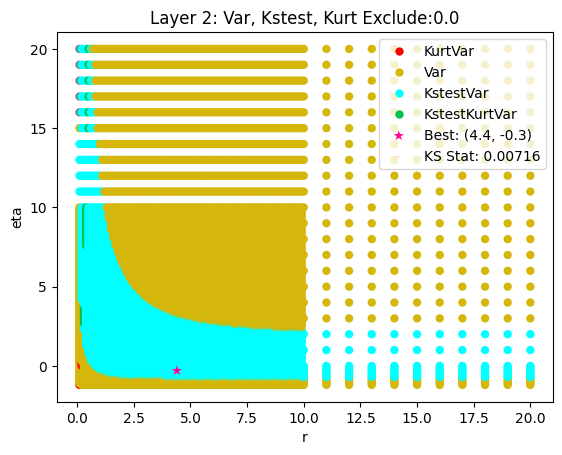

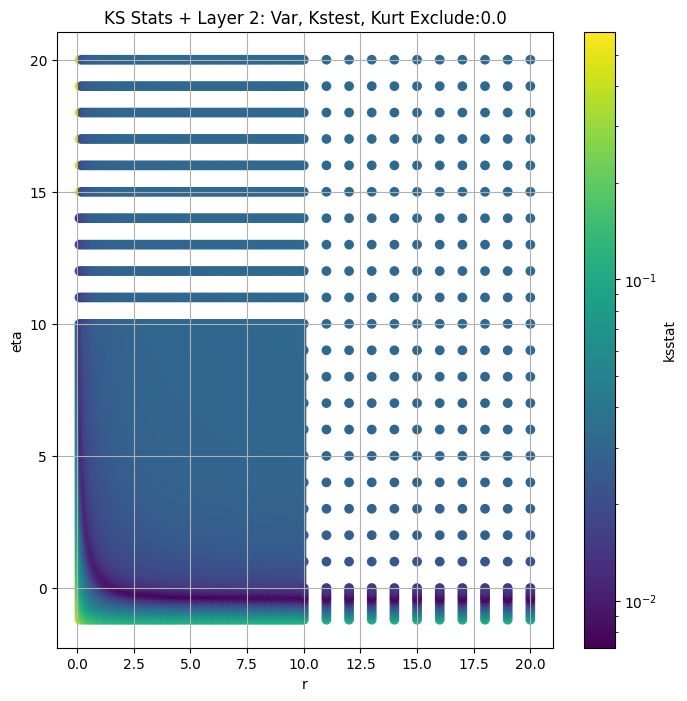

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.007321721398655112 820.2145


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.007771074105568945 754.0612


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.00968885379897104 708.48364


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.01227774535327987 671.3194


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.015506595326329982 639.54694


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.021908969872714124 585.8646


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.027864518020652818 541.04803


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.033200434684415636 502.17868


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.03825746869992041 468.34515


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.043052510672493015 438.71924


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.05712205272308671 366.52402
Number of samples: 9784, Without approximation : 9784.0


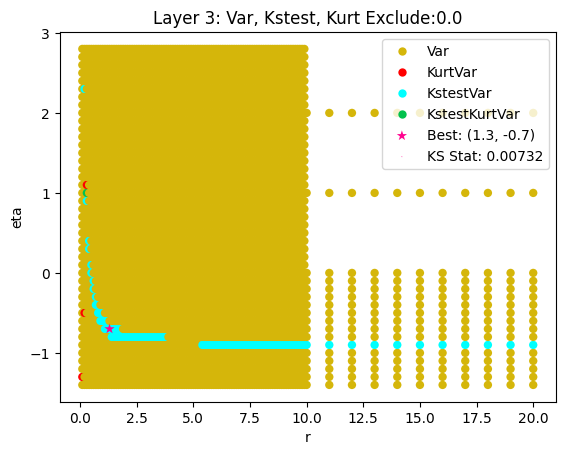

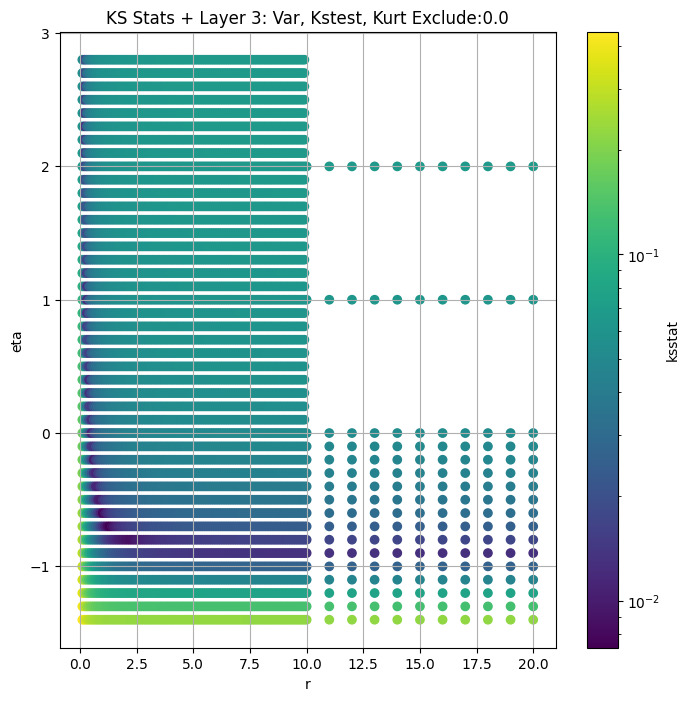

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.005975724826659978 189.17796


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.006492796985036464 182.1598


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.006241858551210733 177.19724


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.00606191783901866 172.84991


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.00660939769536556 168.9983


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.008070351596868041 162.23318


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.009422334394938007 156.31242


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.010690623025340767 151.05133


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.01192375917838778 146.25618


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.013121468993960606 141.8355


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.01761651813256182 130.12767
Number of samples: 39136, Without approximation : 39136.0


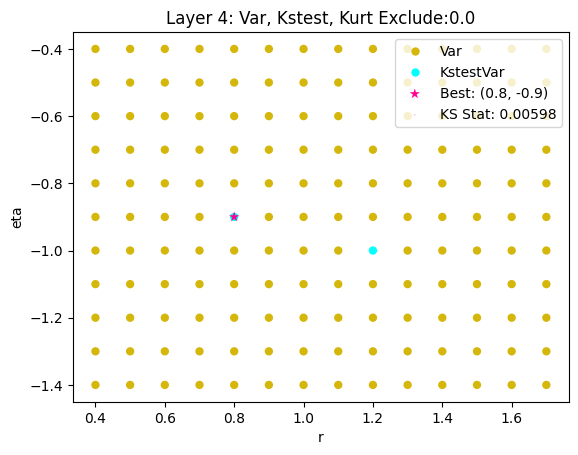

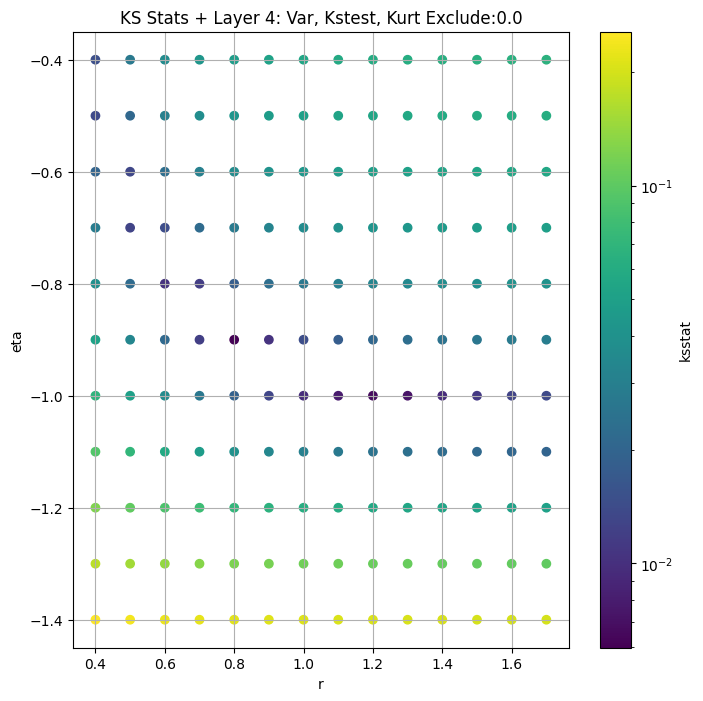

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.006270039627820551 42.68354


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.007882792067951658 41.434647


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.008709439909345251 40.674698


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.008212873980099844 40.051834


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.007453244888377175 39.49758


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.00786682621335899 38.49477


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.007915608944285779 37.601917


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.007666157217043758 36.791


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.008285553001496138 36.038074


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.00889375630386955 35.333042


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.010327464043278584 33.45493
Number of samples: 100000, Without approximation : 156544.0


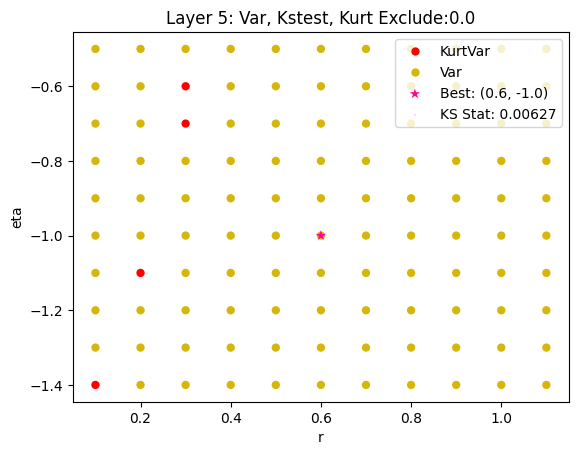

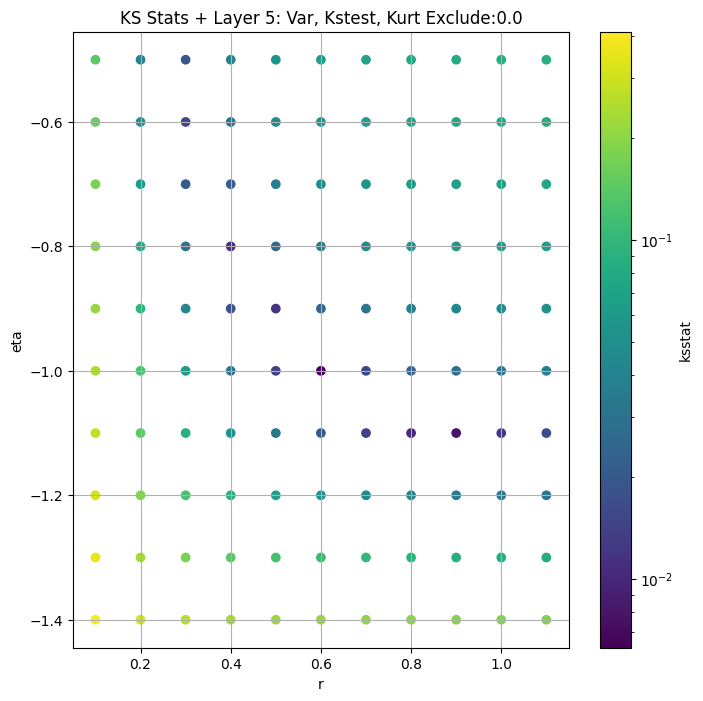

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.013823495999203628 9.066797


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.013648977433808385 8.750053


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.013539490252378661 8.559282


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.013443872591769601 8.396881


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.013378168782300137 8.252037


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.013934886958183568 7.9940553


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.014328127163393656 7.7654486


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.014195768978081225 7.558667


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.014072059943089077 7.368588


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.013953452837463576 7.192668


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.013624225833111292 6.727564
Number of samples: 100000, Without approximation : 626176.0


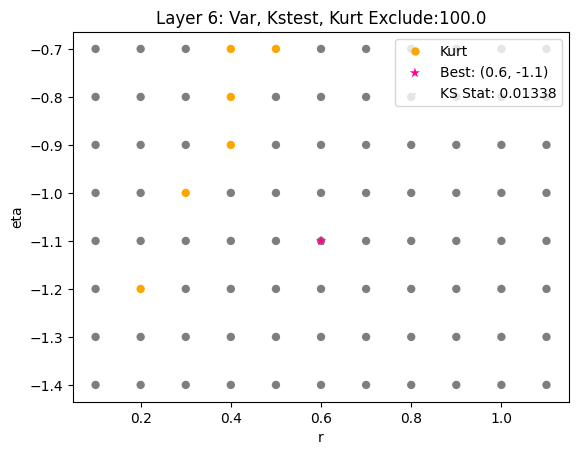

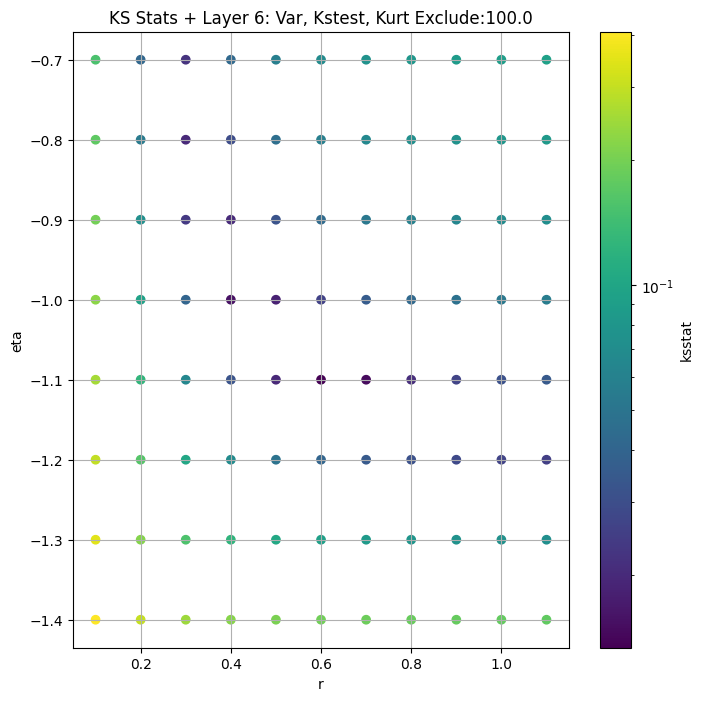

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.02263447865658752 1.8833008


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.022040854803016152 1.7851866


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.02173567553538369 1.7372099


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.021469152483982623 1.6964916


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.022168724194080225 1.6601623


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.02292624550964678 1.5964351


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.0225375079320026 1.5410815


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.022175500794687886 1.4917015


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.021833305528135505 1.4468055


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.021986507805088484 1.4056623


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.022217116870498932 1.2987403
Number of samples: 100000, Without approximation : 2504704.0


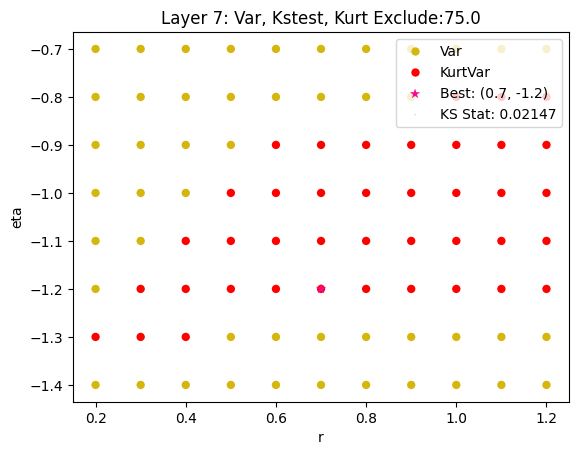

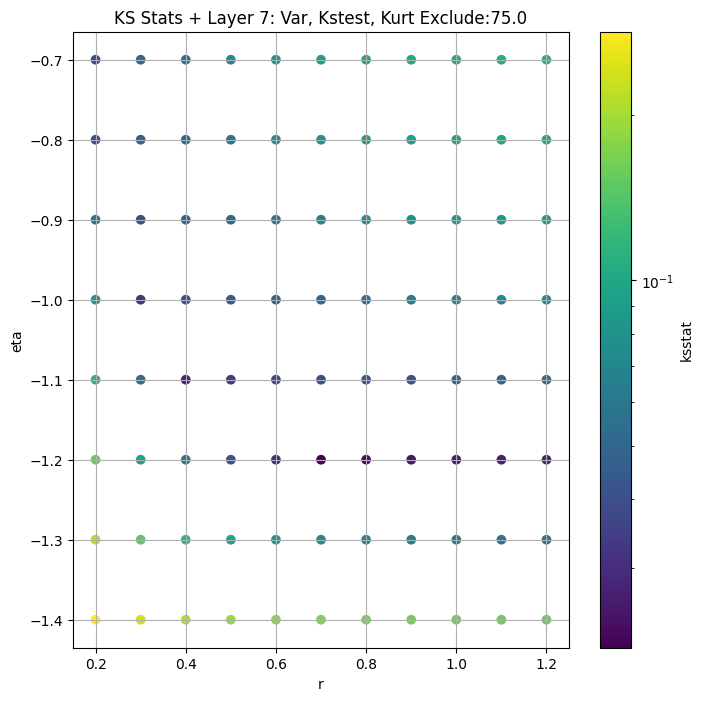

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.007130501290328217 0.43890843


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.009770137773685073 0.40919283


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.011052746697000404 0.39621142


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.011018758052093625 0.38535866


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.010898029530360231 0.37575972


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.008217326299853167 0.35904756


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.007396814316826927 0.34463832


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.006912533180413516 0.33190843


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.007414999704201508 0.32046175


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.00842918445805401 0.31004798


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.009300927780362844 0.2833818
Number of samples: 100000, Without approximation : 10018816.0


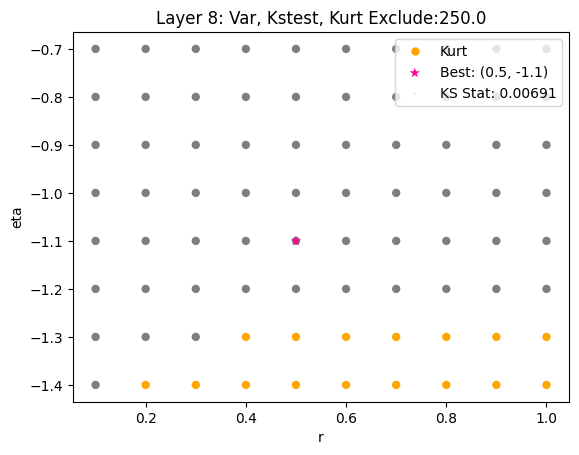

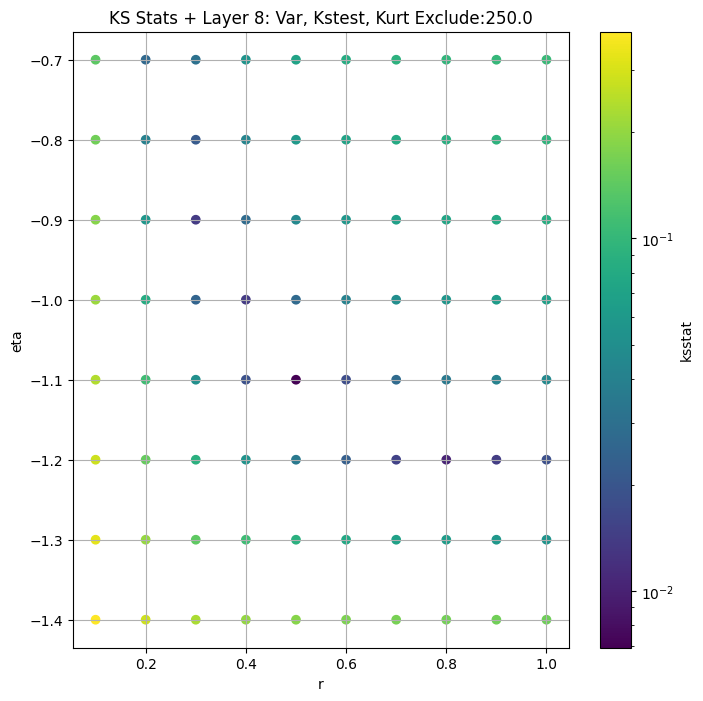

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.01019221521694208 0.12181997


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.00737779497883162 0.11248712


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.006032961546944604 0.108735755


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.005049161228648957 0.10561923


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.006071265650054336 0.102877595


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.008235650292178875 0.09813989


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.010402463923168348 0.09408657


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.012151844368185394 0.09051687


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.01081896476678812 0.087316416


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.011072623871487108 0.08441055


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.010692238215803118 0.077012025
Number of samples: 100000, Without approximation : 40075264.0


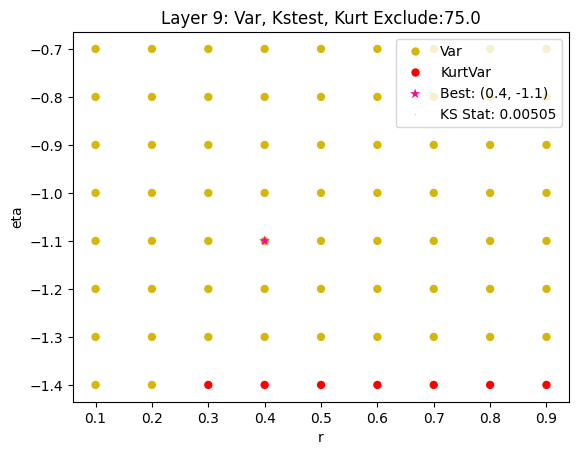

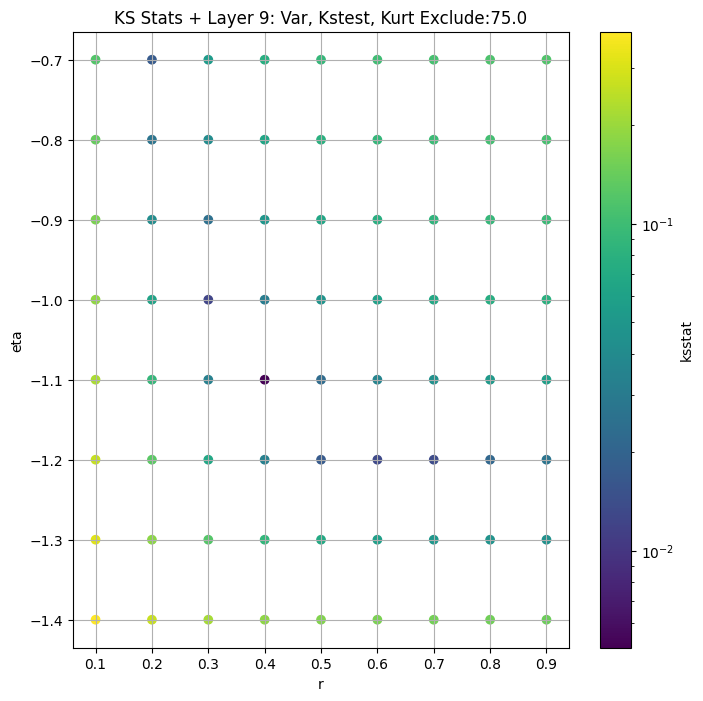

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      3000.960700  2751.604700  3260.011700   0.659391    0.358291   
3       820.214500   777.057400   865.321200   2.262863    1.942622   
4       189.177960   177.314650   201.591720   4.155531    3.484315   
5        42.683540    39.449863    46.217430   7.500519    5.473342   
6         9.066797     8.278472     9.960697  10.757481    7.695960   
7         1.883301     1.680134     2.205375  24.545399   10.354710   
8         0.438908     0.383545     0.550717  45.949707   12.866415   
9         0.121820     0.105568     0.162684  68.626060   13.538338   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.996969         2446.0             0.007158        4.4         -0.3   
3        2.597531         9784.0             0.007322        1.3         -0.7   
4        5.011349        39136.0             0.005976        0.8         -0.9   
5       14.028465       156544.0             0.006270        0.6         -1.0   
6       24.149042       626176.0             0.013378        0.6         -1.1   
7      112.964010      2504704.0             0.021469        0.7         -1.2   
8      233.893920     10018816.0             0.006913        0.5         -1.1   
9      370.638800     40075264.0             0.005049        0.4         -1.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        5599.716296                     0.0         3000.960700   
3        1343.547602                     0.0          820.214500   
4         231.821836                     0.0          189.177960   
5          36.244010                     0.0           42.683540   
6           9.385068                   100.0            8.252037   
7           3.700691                    75.0            1.696492   
8           0.230492                   250.0            0.331908   
9           0.031781                    75.0            0.105619   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.027391  
3                     0.013713  
4                     0.006861  
5                     0.003431  
6                     0.001716  
7                     0.000858  
8                     0.000429  
9                     0.000215

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/153 [00:00<?, ?it/s]

Finding Minimum after computing 153 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.05139219670960282, var: 1813.8114013671875


  0%|          | 0/153 [00:00<?, ?it/s]

Finding Minimum after computing 153 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.04176544068989407, var: 2007.7252197265625


  0%|          | 0/153 [00:00<?, ?it/s]

Finding Minimum after computing 153 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.031130982643786553, var: 2246.68798828125


  0%|          | 0/153 [00:00<?, ?it/s]

Finding Minimum after computing 153 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.02077877763749092, var: 2532.675048828125


  0%|          | 0/153 [00:00<?, ?it/s]

Finding Minimum after computing 153 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.007157995991764164, var: 3000.960693359375
Number of samples: 2446, Without approximation : 2446.0


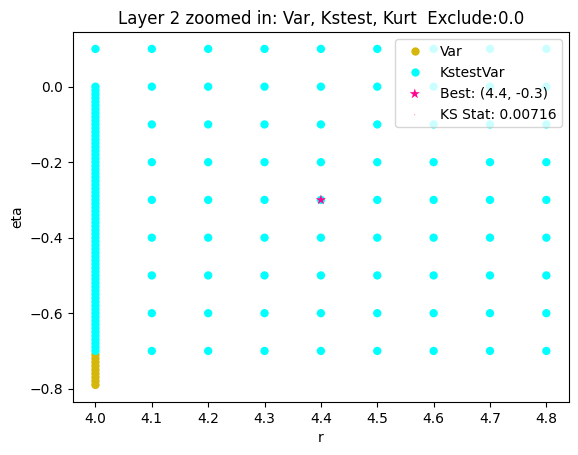

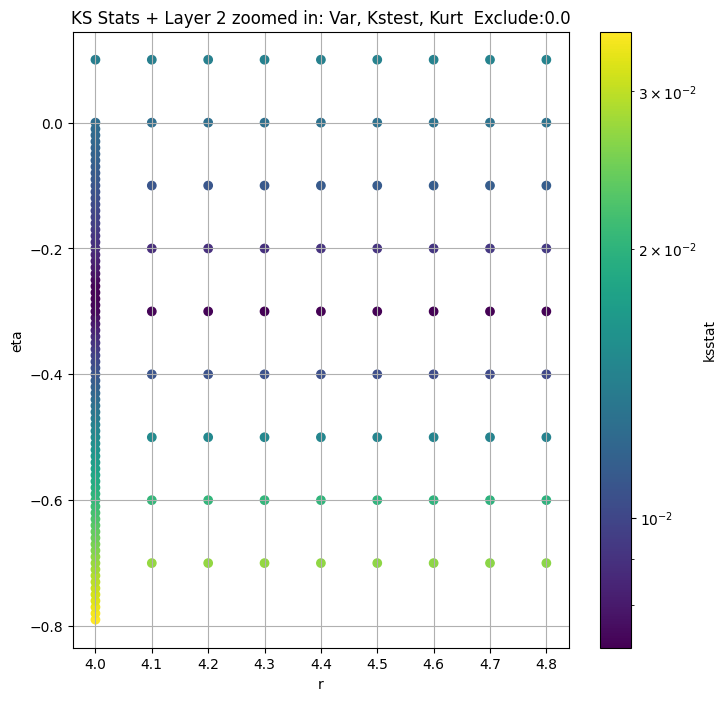

Layer 3


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.018054672296730856, var: 639.5469360351562


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.01479662623139942, var: 671.3193969726562


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.01134991205377632, var: 708.483642578125


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.007655660560026978, var: 754.0612182617188


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.006931492317544641, var: 820.2144775390625
Number of samples: 9784, Without approximation : 9784.0


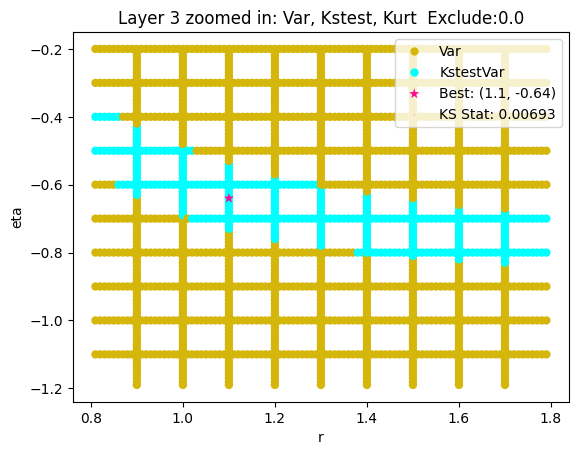

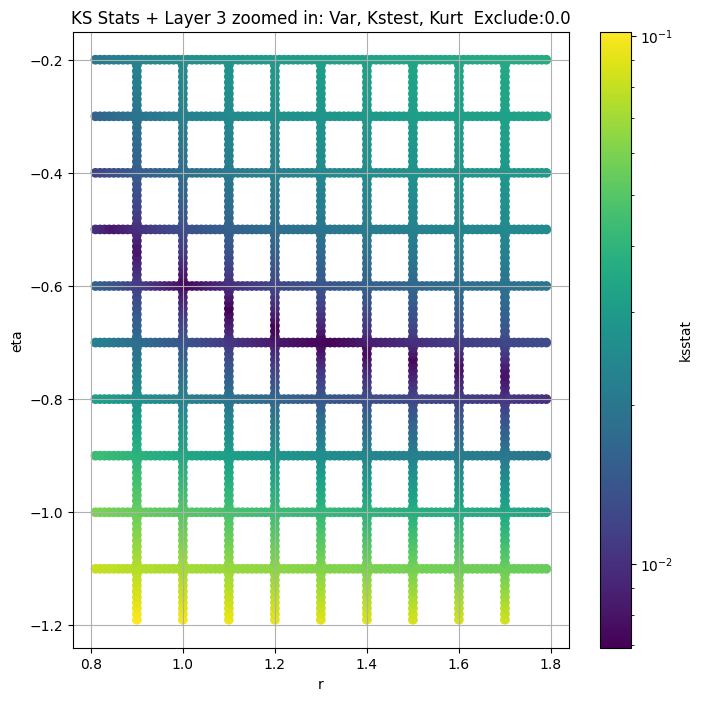

Layer 4


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.008261144937621812, var: 168.99830627441406


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.007085545605258314, var: 172.84991455078125


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.00601976727308251, var: 177.19723510742188


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.005167294610976314, var: 182.15980529785156


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.005031897897468274, var: 189.17796325683594
Number of samples: 39136, Without approximation : 39136.0


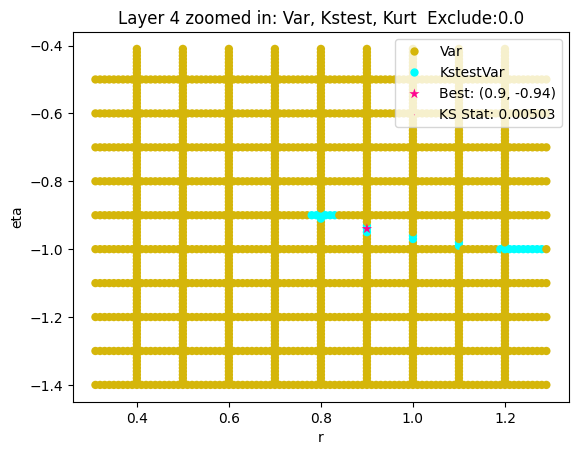

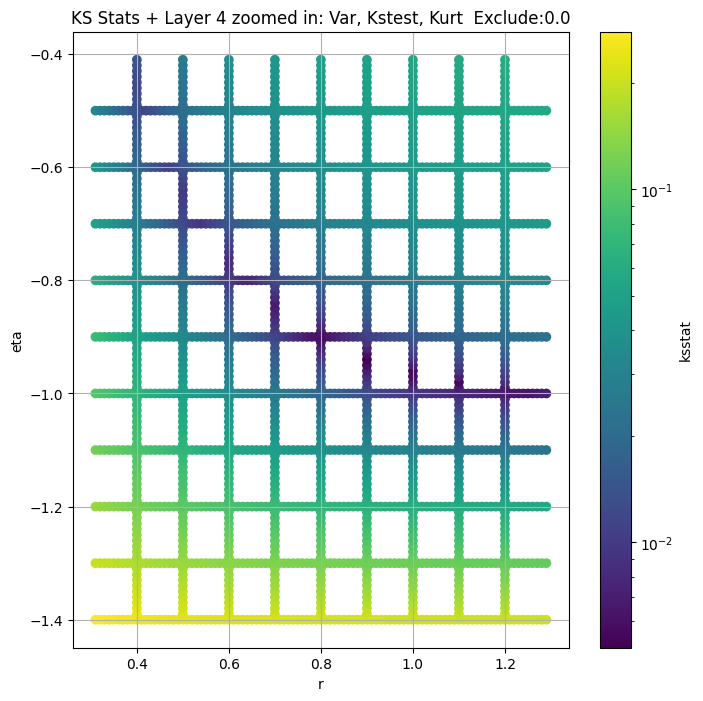

Layer 5


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.0065932425734658295, var: 39.497581481933594


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.006196382920471942, var: 40.05183410644531


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.00568899545082735, var: 40.67469787597656


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.005849664958840879, var: 41.43464660644531


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.005305077476849607, var: 42.68354034423828
Number of samples: 100000, Without approximation : 156544.0


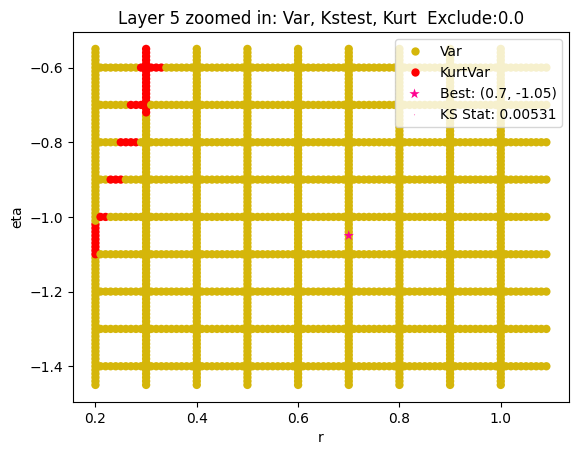

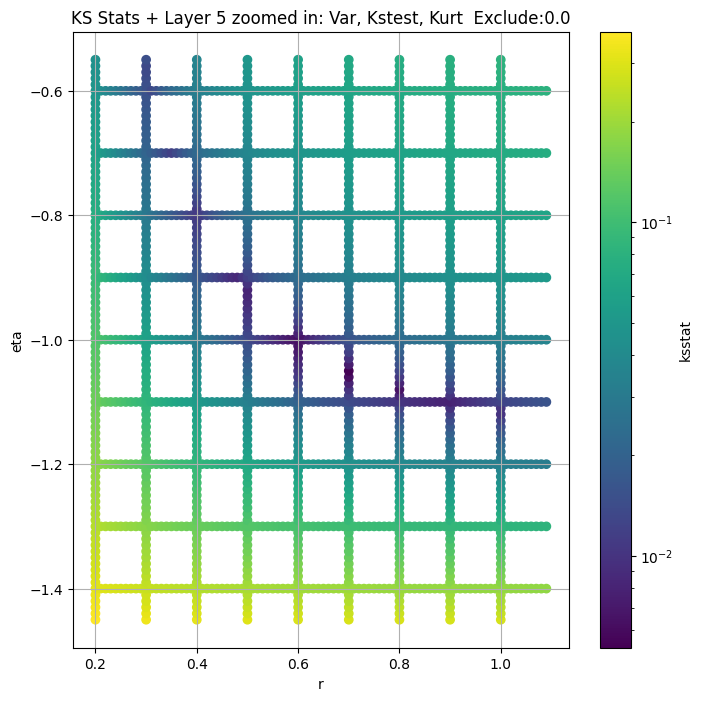

Layer 6


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 100.0 + 100 = 200, ksstat: 0.013341933976408815, var: 7.765448570251465


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 100.0 + 75 = 175, ksstat: 0.013141234118133949, var: 7.876675128936768


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 100.0 + 50 = 150, ksstat: 0.012896894659237712, var: 7.994055271148682


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 100.0 + 25 = 125, ksstat: 0.012759632500224494, var: 8.118547439575195


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 100.0 + 0 = 100, ksstat: 0.013120259424900055, var: 8.252037048339844


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 100.0 + -25 = 75, ksstat: 0.012959807739256812, var: 8.396881103515625


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 100.0 + -50 = 50, ksstat: 0.01305385327892744, var: 8.559282302856445


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 100.0 + -75 = 25, ksstat: 0.013162059898968015, var: 8.750053405761719


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 100.0 + -100 = 0, ksstat: 0.013316255176350489, var: 9.066797256469727
Number of samples: 100000, Without approximation : 626176.0


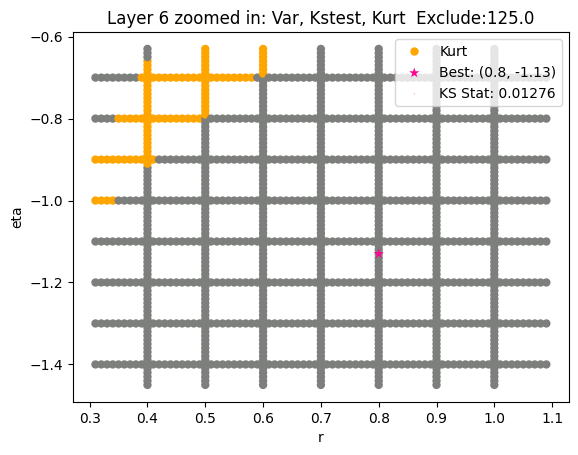

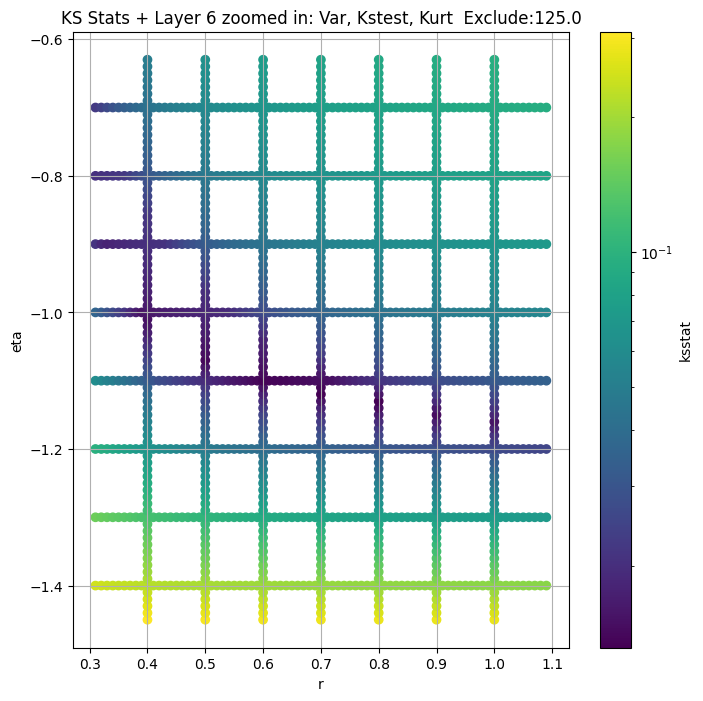

Layer 7


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 75.0 + 100 = 175, ksstat: 0.02014789408067391, var: 1.5678848028182983


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 75.0 + 75 = 150, ksstat: 0.020346795034368426, var: 1.5964350700378418


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 75.0 + 50 = 125, ksstat: 0.02032405595756681, var: 1.6270252466201782


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 75.0 + 25 = 100, ksstat: 0.01971234130129329, var: 1.660162329673767


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 75.0 + 0 = 75, ksstat: 0.019058473104709317, var: 1.6964915990829468


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 75.0 + -25 = 50, ksstat: 0.019260003707912643, var: 1.7372099161148071


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 75.0 + -50 = 25, ksstat: 0.019557735124836495, var: 1.7851866483688354


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 75.0 + -75 = 0, ksstat: 0.019201220180714462, var: 1.88330078125
Number of samples: 100000, Without approximation : 2504704.0


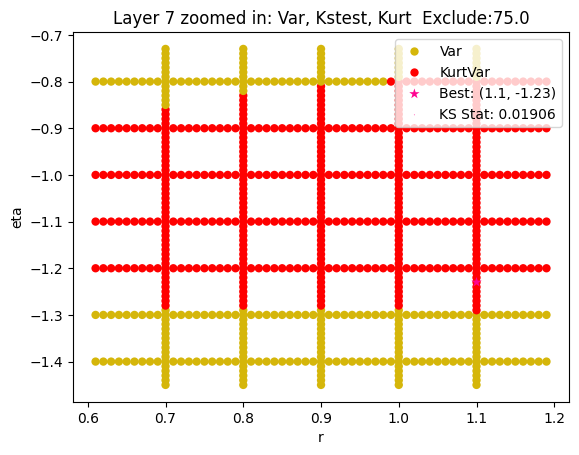

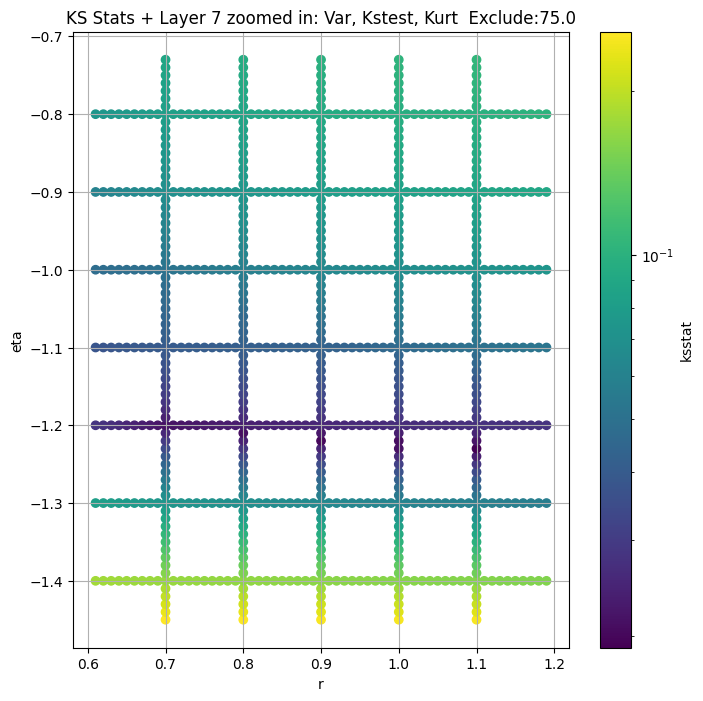

Layer 8


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 250.0 + 100 = 350, ksstat: 0.006720232055532831, var: 0.31004798412323


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 250.0 + 75 = 325, ksstat: 0.00641778439935381, var: 0.31513819098472595


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 250.0 + 50 = 300, ksstat: 0.006441915993043872, var: 0.3204617500305176


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 250.0 + 25 = 275, ksstat: 0.006067789400593666, var: 0.3260435163974762


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 250.0 + 0 = 250, ksstat: 0.00563986490849459, var: 0.3319084346294403


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 250.0 + -25 = 225, ksstat: 0.005949705790460835, var: 0.3380887806415558


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 250.0 + -50 = 200, ksstat: 0.00564219457704453, var: 0.34463831782341003


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 250.0 + -75 = 175, ksstat: 0.005129736377603233, var: 0.35160353779792786


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 250.0 + -100 = 150, ksstat: 0.004604054373671937, var: 0.3590475618839264
Number of samples: 100000, Without approximation : 10018816.0


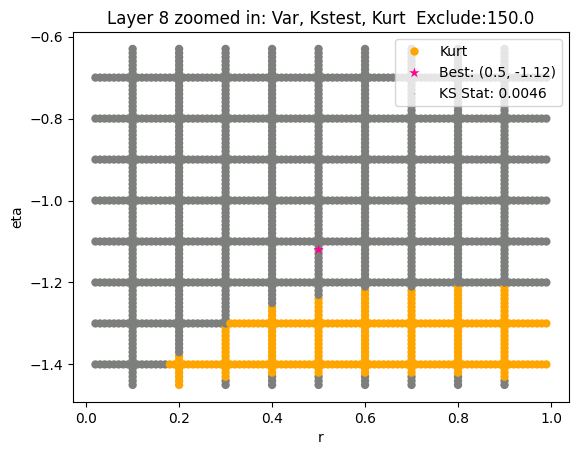

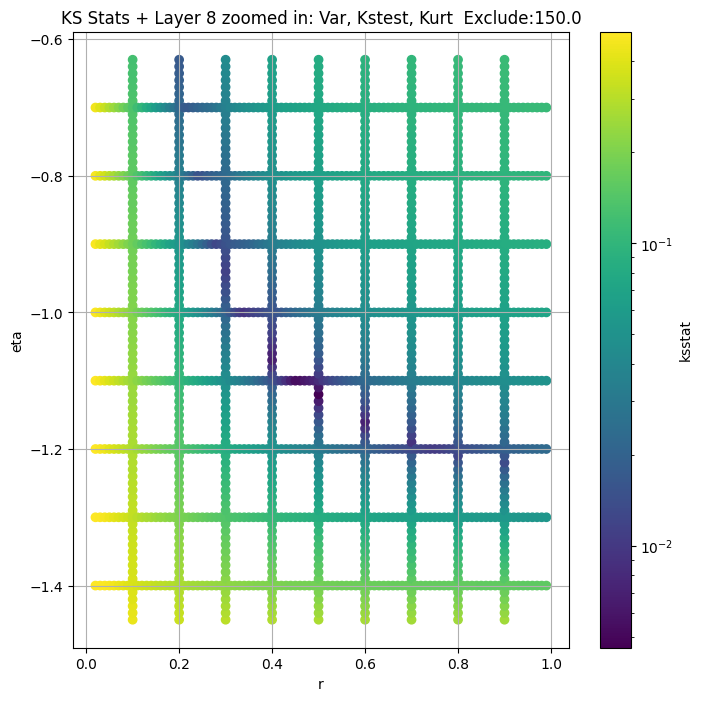

Layer 9


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 75.0 + 100 = 175, ksstat: 0.006759360754077626, var: 0.0960431843996048


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 75.0 + 75 = 150, ksstat: 0.006397304677413618, var: 0.09813988953828812


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 75.0 + 50 = 125, ksstat: 0.006211256440861734, var: 0.10040464252233505


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 75.0 + 25 = 100, ksstat: 0.006024197794066766, var: 0.10287759453058243


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 75.0 + 0 = 75, ksstat: 0.005049161228648957, var: 0.10561922937631607


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 75.0 + -25 = 50, ksstat: 0.005226532929082817, var: 0.10873575508594513


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 75.0 + -50 = 25, ksstat: 0.005075967615920607, var: 0.11248712241649628


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 75.0 + -75 = 0, ksstat: 0.005549466354732746, var: 0.12181997299194336
Number of samples: 100000, Without approximation : 40075264.0


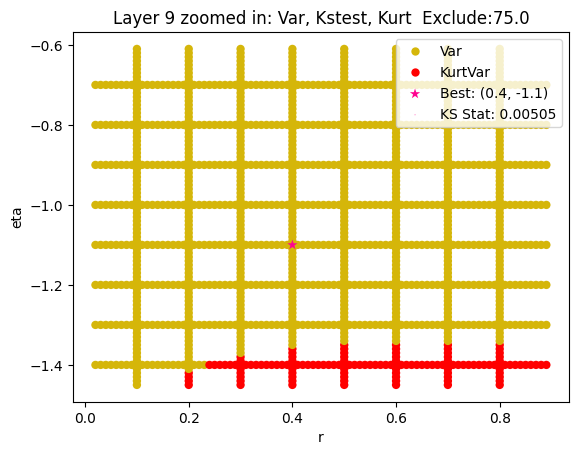

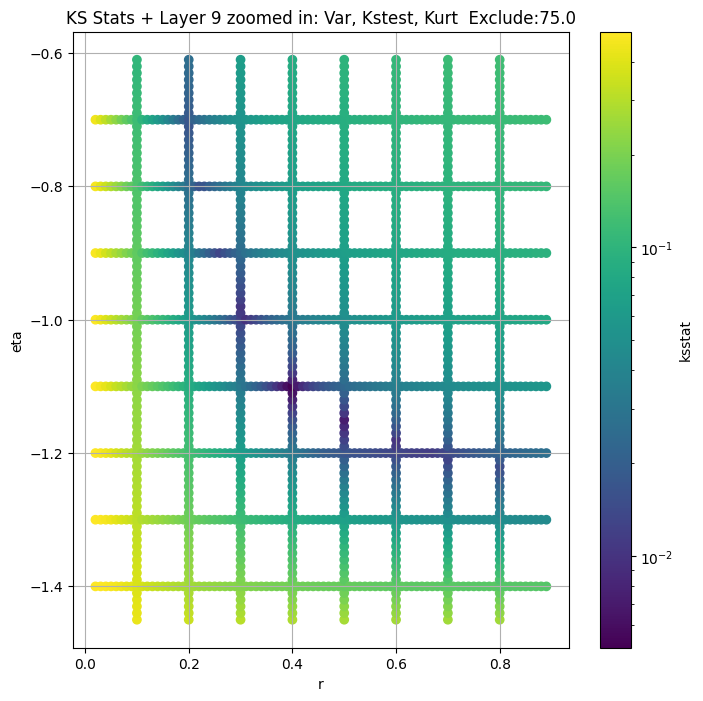

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      3000.960700  2751.604700  3260.011700   0.659391    0.358291   
3       820.214500   777.057400   865.321200   2.262863    1.942622   
4       189.177960   177.314650   201.591720   4.155531    3.484315   
5        42.683540    39.449863    46.217430   7.500519    5.473342   
6         9.066797     8.278472     9.960697  10.757481    7.695960   
7         1.883301     1.680134     2.205375  24.545399   10.354710   
8         0.438908     0.383545     0.550717  45.949707   12.866415   
9         0.121820     0.105568     0.162684  68.626060   13.538338   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.996969         2446.0             0.007158        4.4         -0.3   
3        2.597531         9784.0             0.007322        1.3         -0.7   
4        5.011349        39136.0             0.005976        0.8         -0.9   
5       14.028465       156544.0             0.006270        0.6         -1.0   
6       24.149042       626176.0             0.013378        0.6         -1.1   
7      112.964010      2504704.0             0.021469        0.7         -1.2   
8      233.893920     10018816.0             0.006913        0.5         -1.1   
9      370.638800     40075264.0             0.005049        0.4         -1.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        5599.716296                     0.0         3000.960700   
3        1343.547602                     0.0          820.214478   
4         231.821836                     0.0          189.177963   
5          36.244010                     0.0           42.683540   
6           9.385068                   100.0            8.118547   
7           3.700691                    75.0            1.696492   
8           0.230492                   250.0            0.359048   
9           0.031781                    75.0            0.105619   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.027391          0.007158     4.4     -0.30   
3                     0.013713          0.006931     1.1     -0.64   
4                     0.006861          0.005032     0.9     -0.94   
5                     0.003431          0.005305     0.7     -1.05   
6                     0.001716          0.012760     0.8     -1.13   
7                     0.000858          0.019058     1.1     -1.23   
8                     0.000429          0.004604     0.5     -1.12   
9                     0.000215          0.005049     0.4     -1.10   

        best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                 
2      5599.716296                  0.0        35254  
3      1071.941183                  0.0        37147  
4       297.669922                  0.0        74296  
5        57.824674                  0.0        66042  
6        17.063013                125.0        11007  
7         6.732074                 75.0         4892  
8         0.268427                150.0        88056  
9         0.031781                 75.0        74296

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

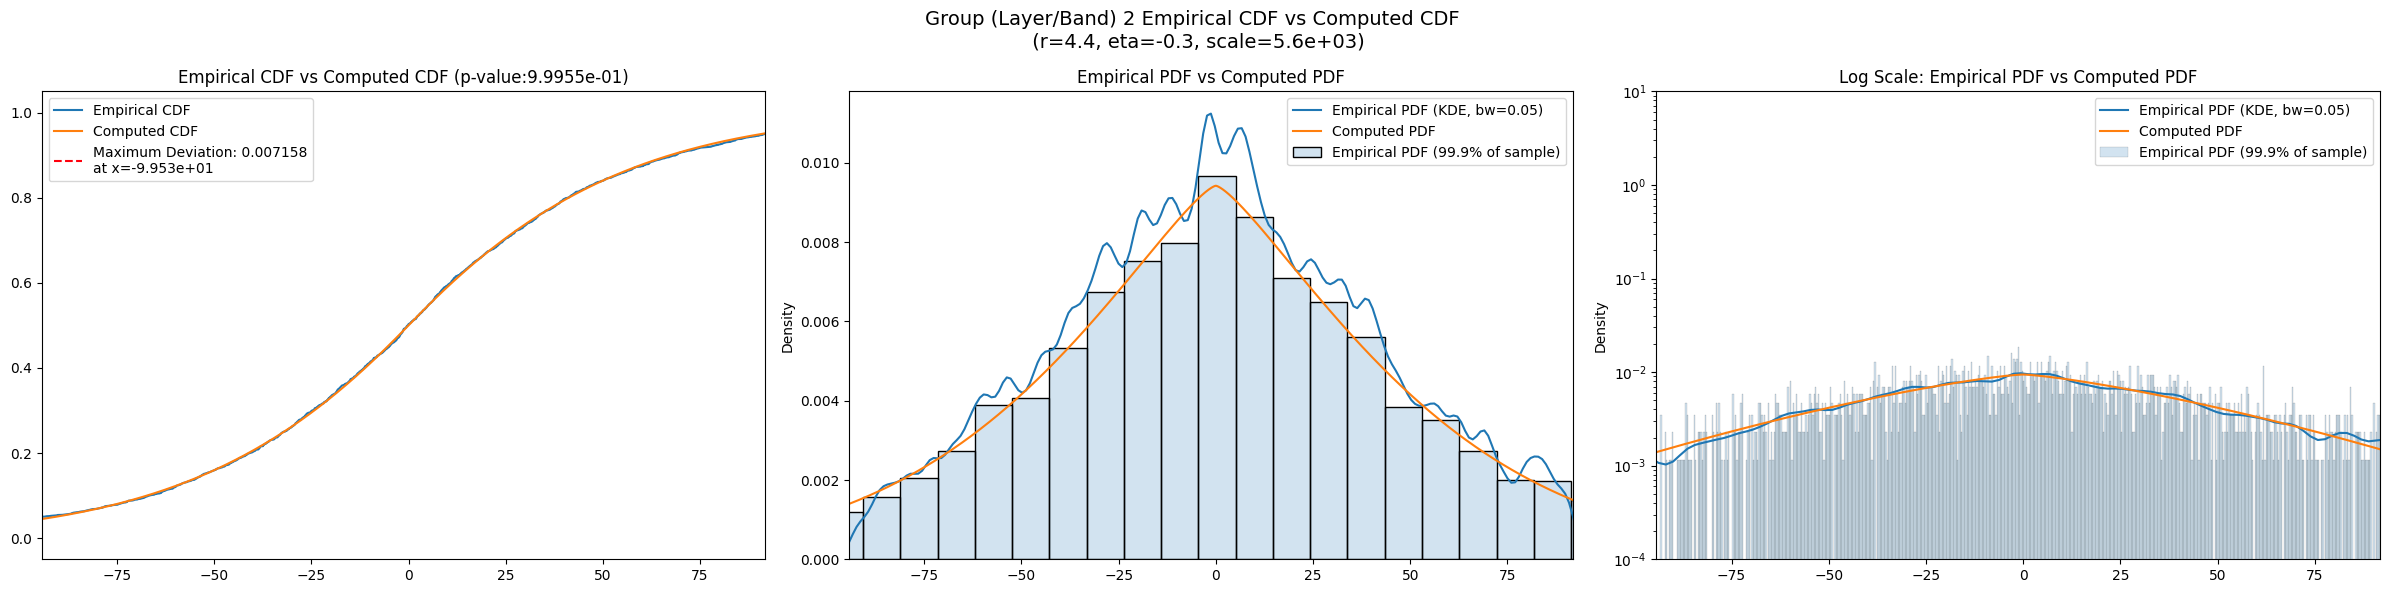

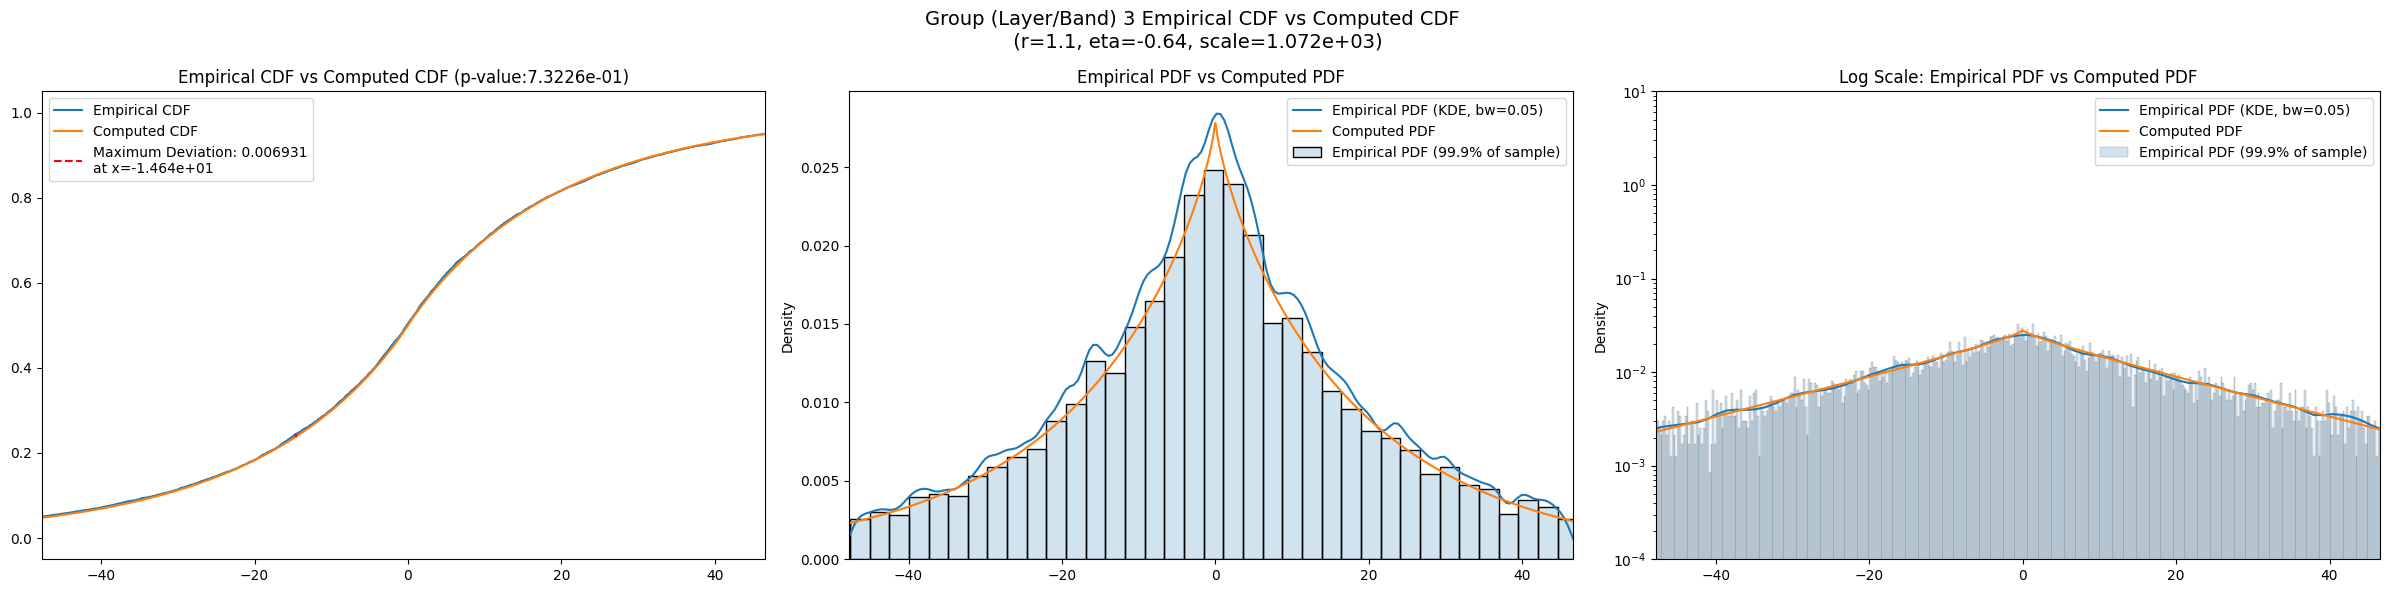

C:\Users\yashd\AppData\Local\Temp\ipykernel_15460\82260372.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)
C:\Users\yashd\AppData\Local\Temp\ipykernel_15460\82260372.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)


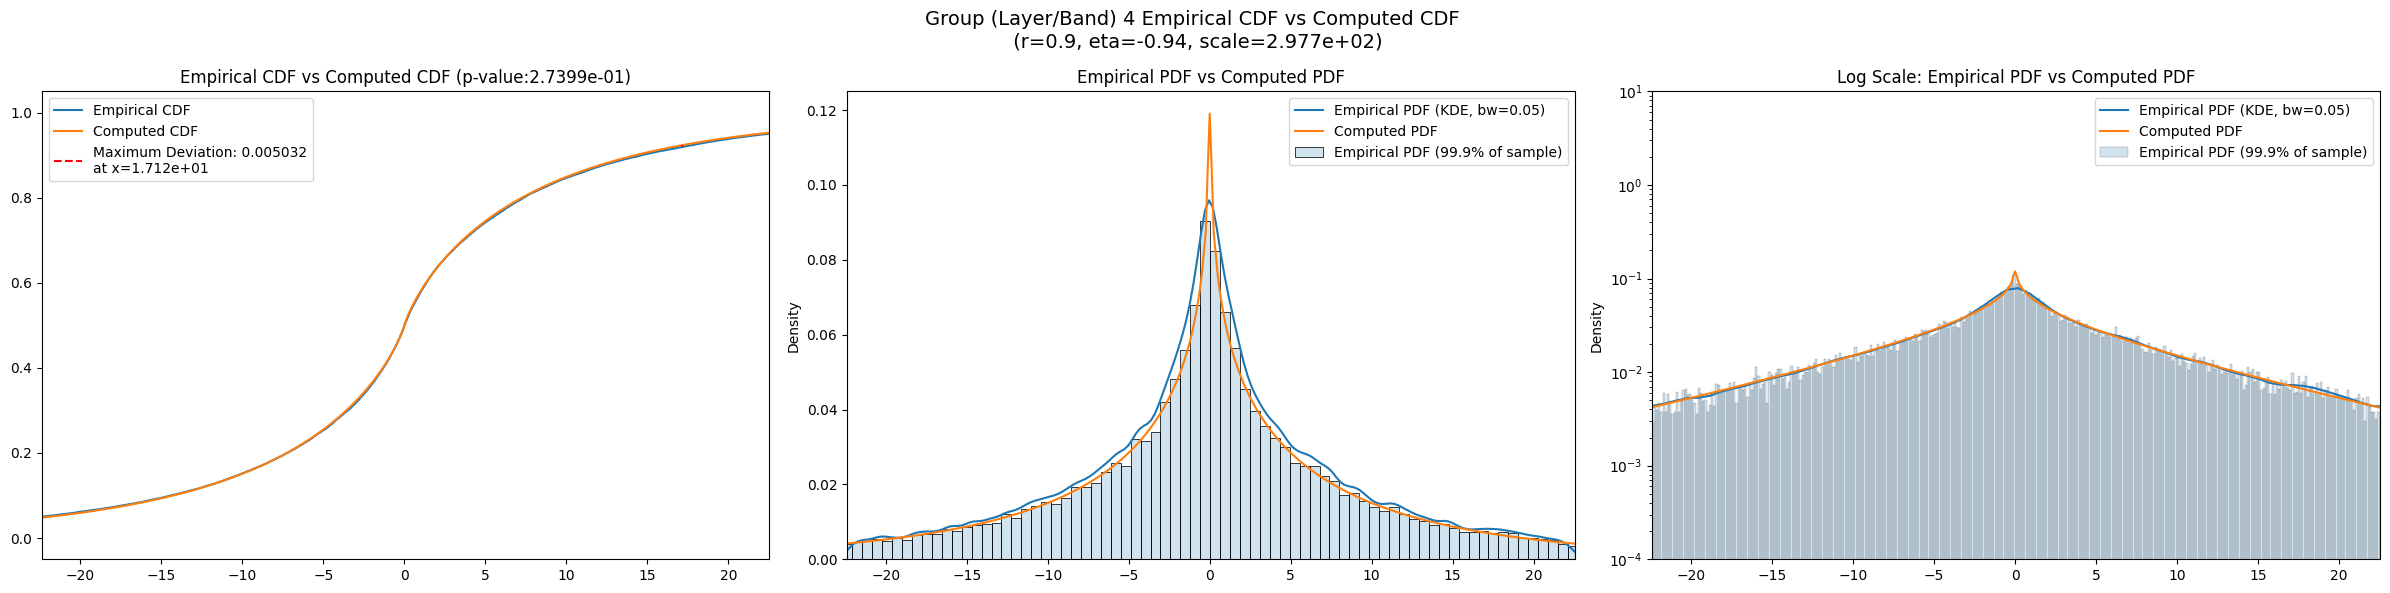

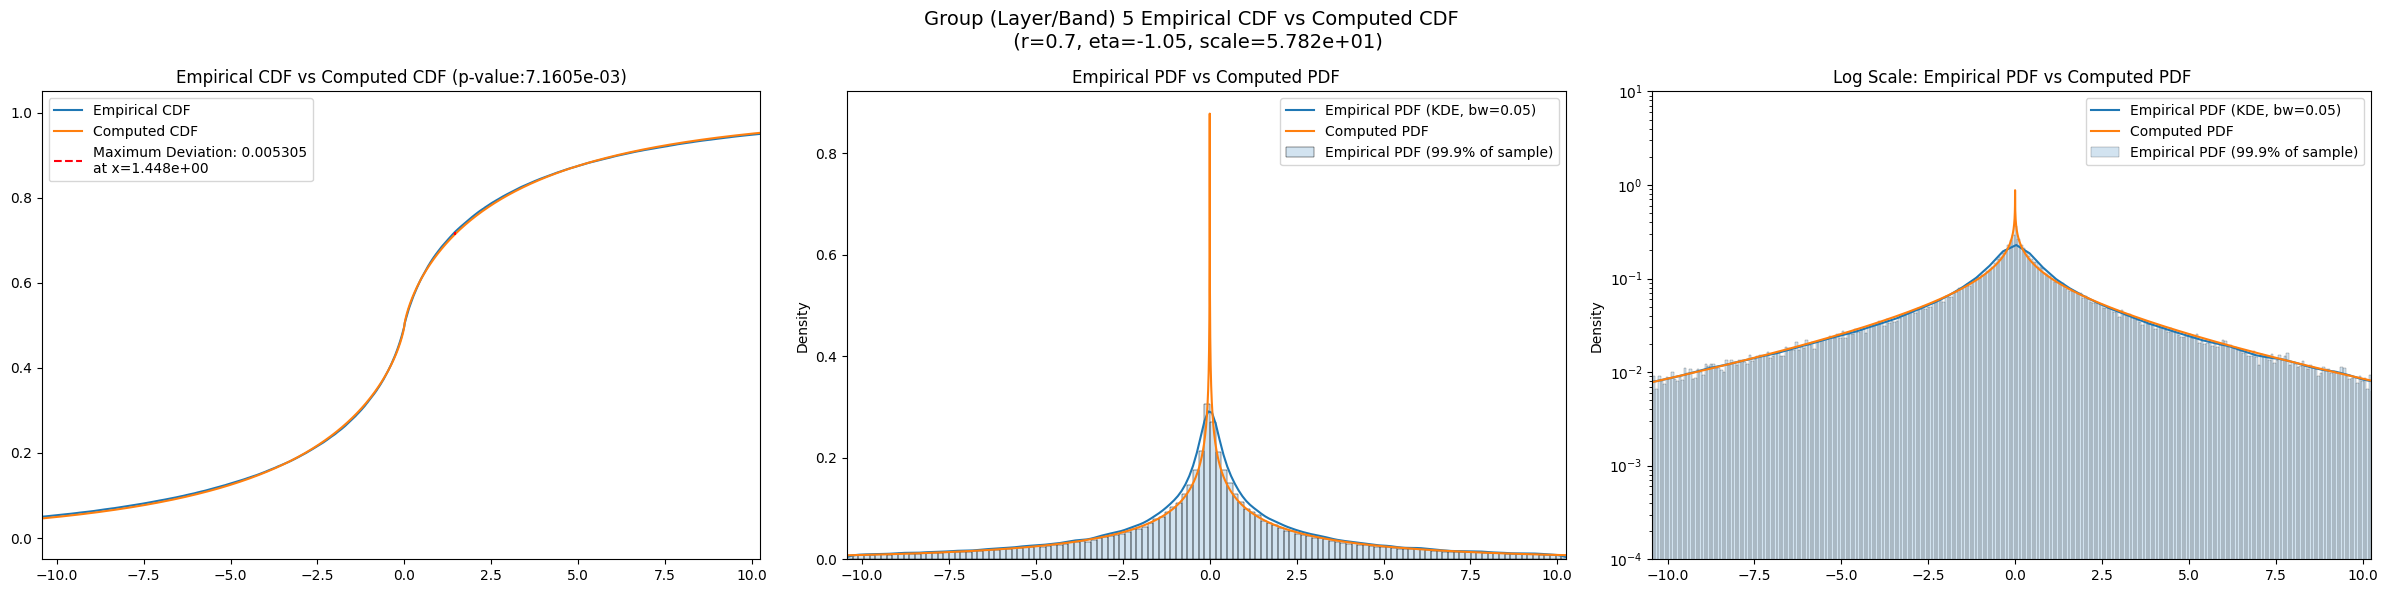

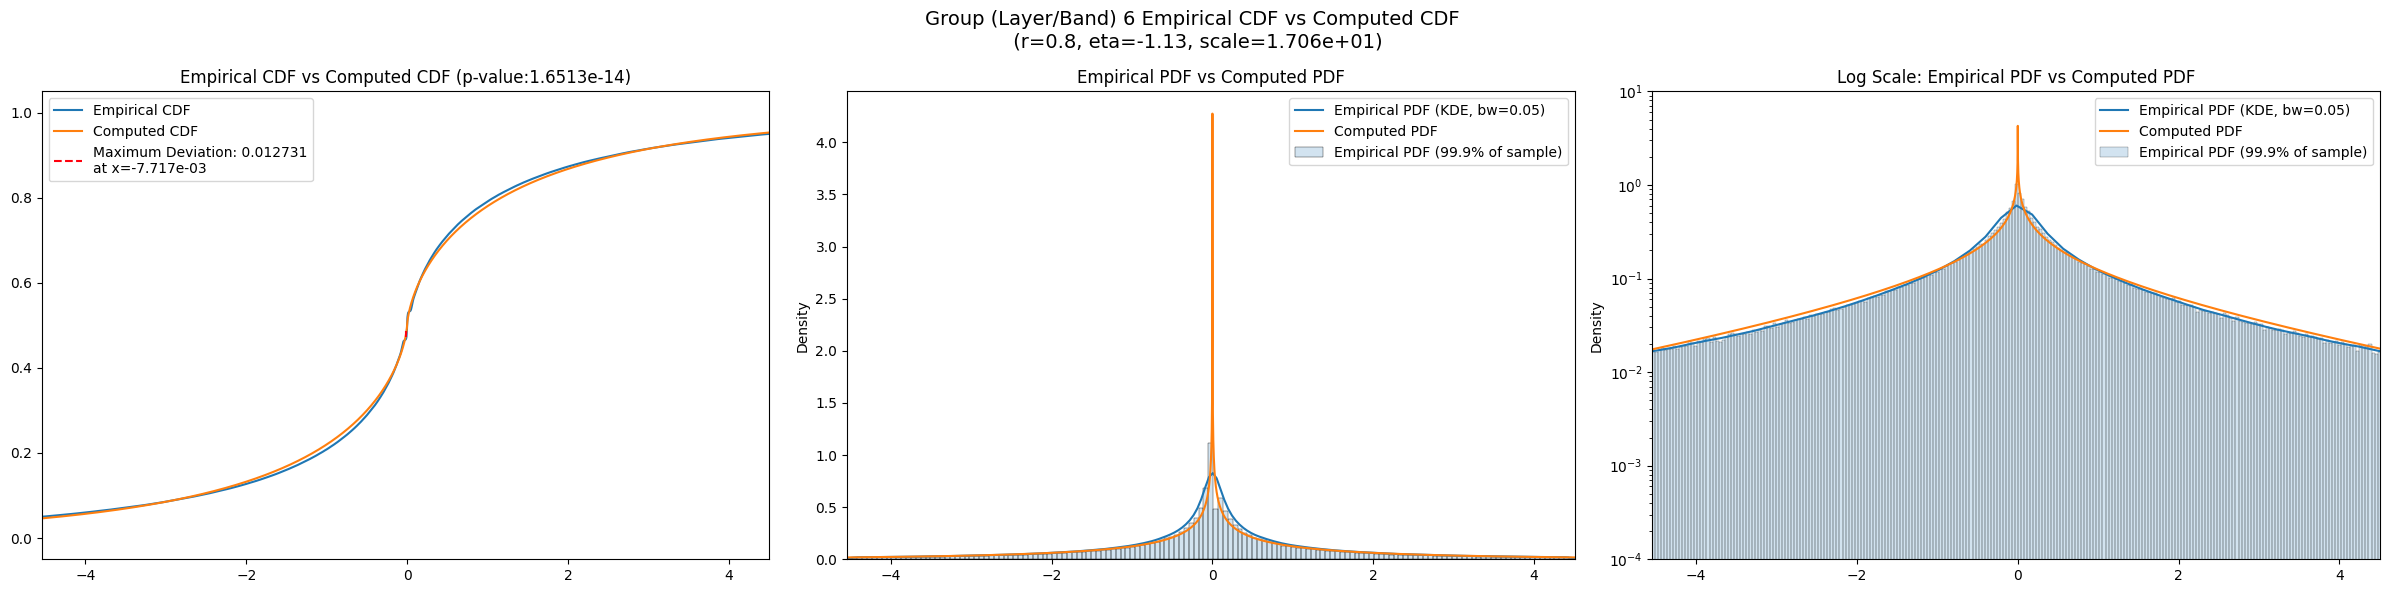

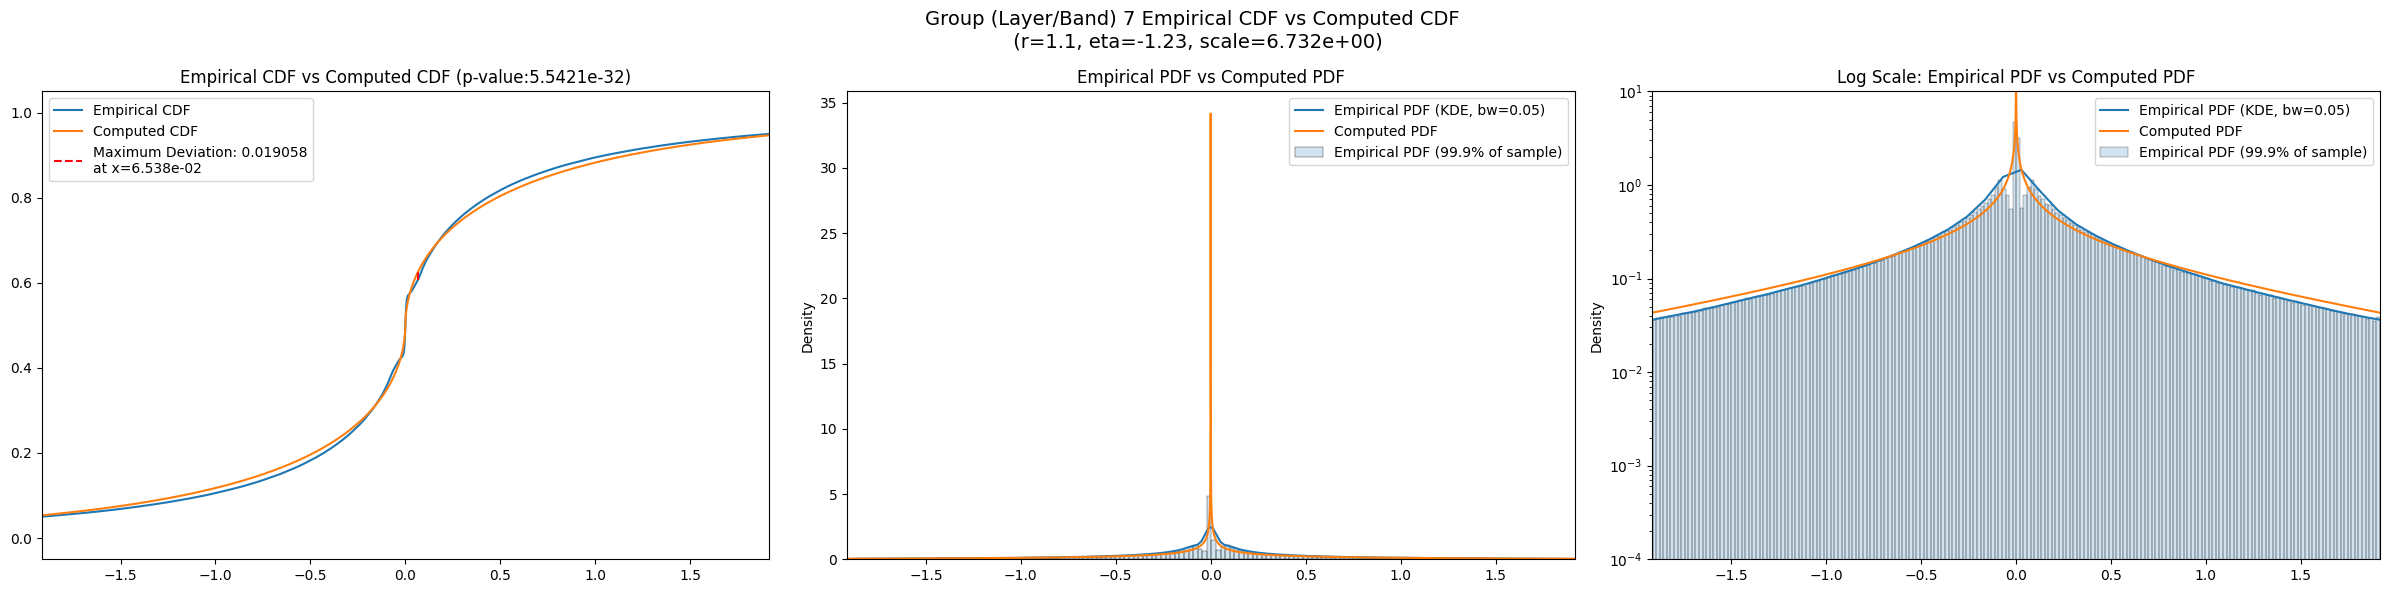

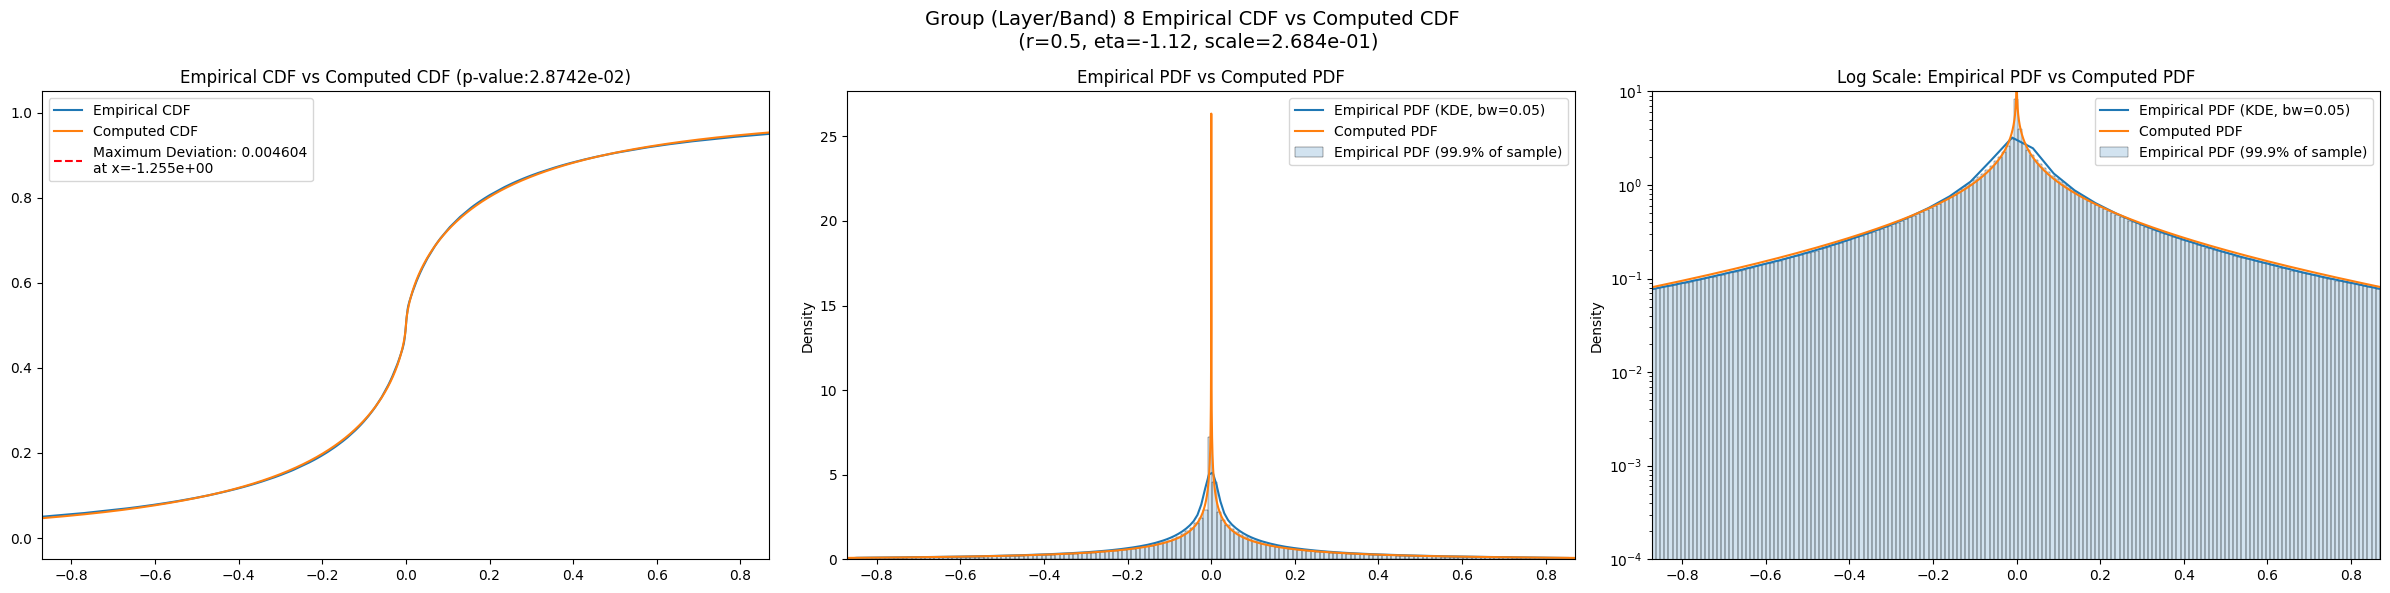

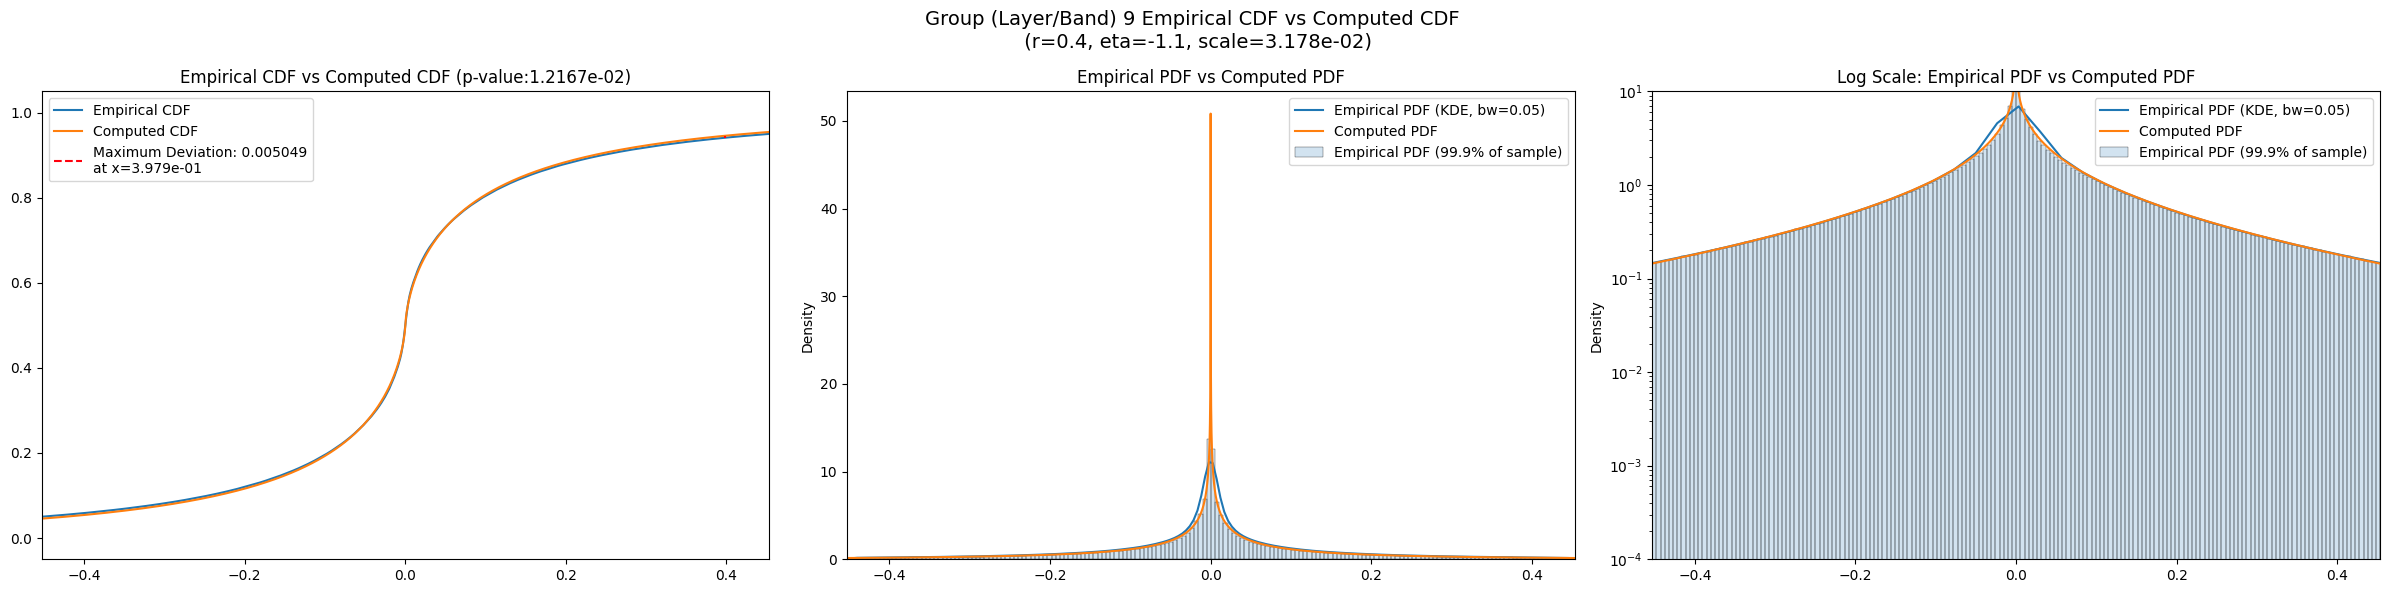

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      3000.960700  2751.604700  3260.011700   0.659391    0.358291   
3       820.214500   777.057400   865.321200   2.262863    1.942622   
4       189.177960   177.314650   201.591720   4.155531    3.484315   
5        42.683540    39.449863    46.217430   7.500519    5.473342   
6         9.066797     8.278472     9.960697  10.757481    7.695960   
7         1.883301     1.680134     2.205375  24.545399   10.354710   
8         0.438908     0.383545     0.550717  45.949707   12.866415   
9         0.121820     0.105568     0.162684  68.626060   13.538338   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.996969         2446.0             0.007158        4.4         -0.3   
3        2.597531         9784.0             0.007322        1.3         -0.7   
4        5.011349        39136.0             0.005976        0.8         -0.9   
5       14.028465       156544.0             0.006270        0.6         -1.0   
6       24.149042       626176.0             0.013378        0.6         -1.1   
7      112.964010      2504704.0             0.021469        0.7         -1.2   
8      233.893920     10018816.0             0.006913        0.5         -1.1   
9      370.638800     40075264.0             0.005049        0.4         -1.1   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       50.796600              0.020344          2.599310e-01   
3      ...       22.418100              0.036140          1.541910e-11   
4      ...        9.032740              0.052790          3.133960e-95   
5      ...        3.532590              0.065490          0.000000e+00   
6      ...        1.362210              0.072590          0.000000e+00   
7      ...        0.546418              0.074764          0.000000e+00   
8      ...        0.244381              0.074992          0.000000e+00   
9      ...        0.116884              0.082434          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          44.786000             0.017659         4.257090e-01  35.736600   
3          19.570200             0.009374         3.540260e-01  16.239500   
4           7.826340             0.025715         6.477230e-23   6.305250   
5           3.049600             0.038990        3.252220e-207   2.420200   
6           1.176700             0.046842         0.000000e+00   0.918339   
7           0.439625             0.055894         0.000000e+00   0.343156   
8           0.211179             0.049803         0.000000e+00   0.163094   
9           0.099577             0.058197         0.000000e+00   0.077130   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.023107   1.444790e-01          9.995540e-01  
3           0.015699   1.592000e-02          7.322626e-01  
4           0.029418   7.388460e-30          2.739942e-01  
5           0.041383  2.203140e-233          2.969541e-04  
6           0.047962   0.000000e+00          5.552269e-89  
7           0.057066   0.000000e+00          0.000000e+00  
8           0.050631   0.000000e+00         6.850277e-185  
9           0.059480   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.007158                 0.027391          0.007158   
3                 0.007322                 0.013713          0.006931   
4                 0.005976                 0.006861          0.005032   
5                 0.006270                 0.003431          0.005305   
6                 0.013378                 0.001716          0.012760   
7                 0.021469                 0.000858          0.019058   
8                 0.006913                 0.000429          0.004604   
9                 0.005049                 0.000215          0.005049   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.020344             0.017659       0.023107  
3                  0.036140             0.009374       0.015699  
4                  0.052790             0.025715       0.029418  
5                  0.065490             0.038990       0.041383  
6                  0.072590             0.046842       0.047962  
7                  0.074764             0.055894       0.057066  
8                  0.074992             0.049803       0.050631  
9                  0.082434             0.058197       0.059480

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta   best_scale  \
layer                                                                        
2             3000.960700          0.007158     4.4     -0.30  5599.716296   
3              820.214478          0.006931     1.1     -0.64  1071.941183   
4              189.177963          0.005032     0.9     -0.94   297.669922   
5               42.683540          0.005305     0.7     -1.05    57.824674   
6                8.118547          0.012760     0.8     -1.13    17.063013   
7                1.696492          0.019058     1.1     -1.23     6.732074   
8                0.359048          0.004604     0.5     -1.12     0.268427   
9                0.105619          0.005049     0.4     -1.10     0.031781   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                    125.0  
7                     75.0  
8                    150.0  
9                     75.0